In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Applications/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
train = pd.read_csv('Competition_Train.csv')
test = pd.read_csv('Competition_Test.csv')

In [3]:
train['potential_issue'] = train['potential_issue'].astype('int')
train['deck_risk'] = train['deck_risk'].astype('int')
train['oe_constraint'] = train['oe_constraint'].astype('int')
train['ppap_risk'] = train['ppap_risk'].astype('int')
train['stop_auto_buy'] = train['stop_auto_buy'].astype('int')
train['went_on_backorder'] = train['went_on_backorder'].astype('int')
train['rev_stop'] = train['rev_stop'].astype('int')



In [4]:
test['potential_issue'] = test['potential_issue'].astype('int')
test['deck_risk'] = test['deck_risk'].astype('int')
test['oe_constraint'] = test['oe_constraint'].astype('int')
test['ppap_risk'] = test['ppap_risk'].astype('int')
test['stop_auto_buy'] = test['stop_auto_buy'].astype('int')
test['rev_stop'] = test['rev_stop'].astype('int')

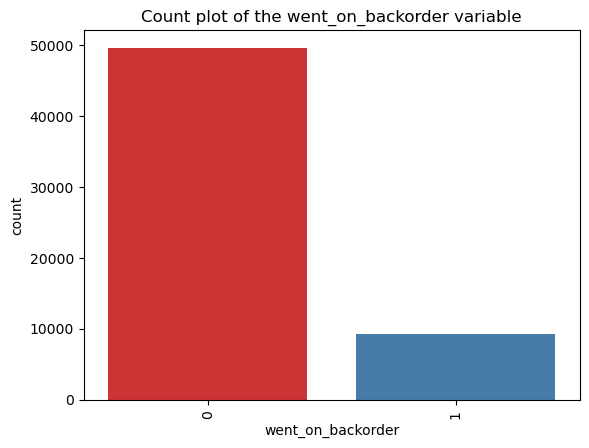

In [5]:
# Plot count plot
sns.countplot(x='went_on_backorder', data=train, palette='Set1', order=[0, 1])
plt.title("Count plot of the went_on_backorder variable")
plt.xticks(rotation=90)
plt.show()

In [5]:
from sklearn.utils import resample

# Separate the classes
majority_class = train[train['went_on_backorder'] == 0]
minority_class = train[train['went_on_backorder'] == 1]

# Downsample the majority class
downsampled_majority = resample(majority_class, 
                                 replace=False,     # Sample without replacement
                                 n_samples=len(minority_class),    # Match number of samples in minority class
                                 random_state=42)  # Set random state for reproducibility

# Combine the downsampled majority class with the minority class
balanced_data = pd.concat([downsampled_majority, minority_class])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42)

# Now you can use balanced_data for training your model


In [6]:
#balanced_data = balanced_data.drop(['sku'], axis=1)


# Select features with high skewness (absolute skewness value > 1)
high_skew_features = ['national_inv', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 
                      'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 
                      'sales_9_month', 'min_bank', 'pieces_past_due', 'local_bo_qty']

# Apply log transformation to selected features
for feature in high_skew_features:
    balanced_data[feature] = np.log1p(np.abs(balanced_data[feature]))
    
# Calculate skewness after transformation
skewness_after_transformation = balanced_data[high_skew_features].skew()

print("Skewness after transformation:")
print(skewness_after_transformation)


Skewness after transformation:
national_inv        0.946406
in_transit_qty      3.021128
forecast_3_month    0.846378
forecast_6_month    0.660035
forecast_9_month    0.566332
sales_1_month       1.274919
sales_3_month       0.850207
sales_6_month       0.651915
sales_9_month       0.555607
min_bank            1.561128
pieces_past_due     5.612505
local_bo_qty        5.582117
dtype: float64


In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

# Split the data into features (X) and target (y)
X = balanced_data.drop('went_on_backorder', axis=1)
y = balanced_data['went_on_backorder']

# Initialize the neural network classifier
clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=20)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation scores: [0.58817204 0.57849462 0.57526882 0.66989247 0.80752688 0.83978495
 0.54731183 0.62150538 0.60537634 0.51505376 0.61356297 0.82131324
 0.74703983 0.55974166 0.64370291 0.50699677 0.52099031 0.59203445
 0.60602799 0.5080732 ]
Mean CV accuracy: 0.6233935206083545


In [9]:

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 1500, 2000]
}

# Initialize the neural network classifier
clf = MLPClassifier()

# Initialize GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=StratifiedKFold(n_splits=10))

# Perform the grid search
grid_search.fit(X, y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters:", best_params)
print("Best mean CV accuracy:", best_score)


Best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (100,), 'max_iter': 2000}
Best mean CV accuracy: 0.7399139322216245


In [9]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense


# # Define the neural network model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1)  # Output layer (no activation for regression)
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model
# mse = model.evaluate(X_test, y_test)
# print('Mean Squared Error on Test Set:', mse)